# 第8章: 機械学習

本章では，Bo Pang氏とLillian Lee氏が公開しているMovie Review Dataのsentence polarity dataset v1.0を用い，文を肯定的（ポジティブ）もしくは否定的（ネガティブ）に分類するタスク（極性分析）に取り組む．

# 70. データの入手・整形
文に関する極性分析の正解データを用い，以下の要領で正解データ（sentiment.txt）を作成せよ．

1. rt-polarity.posの各行の先頭に"+1 "という文字列を追加する（極性ラベル"+1"とスペースに続けて肯定的な文の内容が続く）
2. rt-polarity.negの各行の先頭に"-1 "という文字列を追加する（極性ラベル"-1"とスペースに続けて否定的な文の内容が続く）
3. 上述1と2の内容を結合（concatenate）し，行をランダムに並び替える

sentiment.txtを作成したら，正例（肯定的な文）の数と負例（否定的な文）の数を確認せよ

In [1]:
import random
# nkfコマンドでバイナリからutf8に変換
with open('rt-polaritydata/pos', 'r') as f:
    sentiment_pos = ["+1 " + x[:-1] for x in f.readlines()]
with open('rt-polaritydata/neg', 'r') as f:
    sentiment_neg = ["-1 " + x[:-1] for x in f.readlines()]
sentiment_pos[0] = sentiment_pos[0].replace("\ufeff","")
sentiment_neg[0] = sentiment_neg[0].replace("\ufeff","")
sentiment = sentiment_pos + sentiment_neg
random.shuffle(sentiment)
with open('sentiment.txt', 'w') as f:
    f.writelines([x + "\n" for x in sentiment])

In [2]:
with open('sentiment.txt', 'r') as f:
    sentiment = [x[:-1] for x in f.readlines()]
    count = len(sentiment)
    count_pos = len([x for x in sentiment if x[:2] == "+1"])
    count_neg = len([x for x in sentiment if x[:2] == "-1"])
count, count_pos, count_neg

(10661, 5330, 5331)

# 71. ストップワード
英語のストップワードのリスト（ストップリスト）を適当に作成せよ．さらに，引数に与えられた単語（文字列）がストップリストに含まれている場合は真，それ以外は偽を返す関数を実装せよ．さらに，その関数に対するテストを記述せよ．

In [3]:
import re
with open('stopwords.csv', 'r') as f:
    stopwords = [x[:-1] for x in f.readlines()]
p = re.compile("^[a-zA-Z|\'|\-|0-9]*$")
def validate(word):
    return (word in stopwords) or not p.match(word) or len(word) == 1

In [4]:
validate('you')

True

In [5]:
validate('aaaaa')

False

# 72. 素性抽出
極性分析に有用そうな素性を各自で設計し，学習データから素性を抽出せよ．素性としては，レビューからストップワードを除去し，各単語をステミング処理したものが最低限のベースラインとなるであろう．

In [6]:
def get_bow(wordlist):
    row = {}
    for word in wordlist:
        if not validate(word):
            w = stem(word)
            if w in row.keys():
                row[w] += 1
            else:
                row[w] = 1
    return row

In [7]:
from stemming.porter2 import stem
wordlist = []
label = []
bow = []
for line in sentiment:
    line_list = line[:-1].split(" ")
    label.append(int(line_list[0]))
    bow.append(get_bow(line_list[1:]))

In [8]:
import pandas as pd
bow_df = pd.DataFrame(bow).fillna(0)

In [9]:
bow_df.head()

,'a,'i,'independ,'n,'s,--,--hope,--with,-a,-after,...,ziyi,zoe,zombi,zombie-land,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 73. 学習
72で抽出した素性を用いて，ロジスティック回帰モデルを学習せよ．

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(bow_df, label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

# 74. 予測
73で学習したロジスティック回帰モデルを用い，与えられた文の極性ラベル（正例なら"+1"，負例なら"-1"）と，その予測確率を計算するプログラムを実装せよ

In [11]:
logreg.predict(bow_df[:5])

array([-1, -1, -1, -1, -1])

In [12]:
bow_df[:5]

,'a,'i,'independ,'n,'s,--,--hope,--with,-a,-after,...,ziyi,zoe,zombi,zombie-land,zone,zooland,zoom,zucker,zwick,zzzzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
label[:5]

[-1, -1, -1, -1, 1]

In [14]:
def get_bow_df(text):
    text_list = [x for x in text.split(" ") if x in bow_df.columns]
    bow_dict = get_bow(text_list)
    return pd.DataFrame([bow_dict], columns=bow_df.columns).fillna(0)

In [15]:
logreg.predict(get_bow_df("i have a pen"))

array([-1])

# 75. 素性の重み
73で学習したロジスティック回帰モデルの中で，重みの高い素性トップ10と，重みの低い素性トップ10を確認せよ．

In [16]:
weight = pd.DataFrame(logreg.coef_[0], index=bow_df.columns, columns=["weight"])

In [17]:
# 重みの高い素性トップ10
weight.sort_values("weight", ascending=False).head(10)

,weight
refresh,2.184563
engross,2.094347
unexpect,1.979437
glorious,1.805681
wonder,1.739558
examin,1.649721
remark,1.624787
smarter,1.613071
beauti,1.602747
resist,1.584557


In [18]:
# 重みの低い素性トップ10
weight.sort_values("weight").head(10)

,weight
bore,-2.278731
wast,-1.904425
fail,-1.897111
dull,-1.880885
mediocr,-1.875136
routin,-1.814219
suppos,-1.715353
flat,-1.708888
generic,-1.659871
worst,-1.648374


# 76. ラベル付け
学習データに対してロジスティック回帰モデルを適用し，正解のラベル，予測されたラベル，予測確率をタブ区切り形式で出力せよ．

In [19]:
predict_proba = logreg.predict_proba(bow_df)
predict = logreg.predict(bow_df)
with open('76.csv', 'w') as f:
    for i, l in enumerate(label):
        line = "\t".join([str(x) for x in [l, predict[i], max(predict_proba[i])]])
        f.write(line + "\n")

# 77. 正解率の計測
76の出力を受け取り，予測の正解率，正例に関する適合率，再現率，F1スコアを求めるプログラムを作成せよ．

In [20]:
result77 = pd.read_csv('76.csv', header=None, sep='\t', names=("label", "predict", "predict_proba"))

In [21]:
def evaluate(result):
    TP = len(result[(result['label'] == 1) & (result['predict'] == 1)])
    FP = len(result[(result['label'] == -1) & (result['predict'] == 1)])
    TN = len(result[(result['label'] == -1) & (result['predict'] == -1)])
    FN = len(result[(result['label'] == 1) & (result['predict'] == -1)])
    # print(TP, FP, TN, FN)
    # print(len(result) == (TP+FP+TN+FN))
    # 正解率
    rate = (TP + TN) / len(result)
    # 適合率
    if (TP + FP) == 0:
        precision = 0
    else:
        precision = TP/(TP + FP)
    # 再現率
    if (TP + FN) == 0:
        recall = 0
    else:
        recall=TP/(TP + FN)
    # F1
    if recall + precision == 0:
        F = 0
    else:
        F = 2 * recall * precision / (recall + precision)
    return {"rate":rate, "precision":precision, "recall":recall, "F":F}

In [22]:
value = evaluate(result77)

In [23]:
value["rate"]

0.9442829002907794

In [24]:
value["precision"]

0.9488248673237301

In [25]:
value["recall"]

0.9392120075046905

In [26]:
value["F"]

0.943993965679804

# 78. 5分割交差検定
76-77の実験では，学習に用いた事例を評価にも用いたため，正当な評価とは言えない．すなわち，分類器が訓練事例を丸暗記する際の性能を評価しており，モデルの汎化性能を測定していない．そこで，5分割交差検定により，極性分類の正解率，適合率，再現率，F1スコアを求めよ．

In [27]:
N = 5
length = len(bow_df) // N
cross_list = []
for i in range(N):
    train_df = (bow_df[:length * i] + bow_df[length * (i + 1):]).fillna(0)
    train_label = label[:length * i] + label[length * (i + 1):]
    test_df = bow_df[length * i:length * (i + 1)]
    test_label = label[length * i:length * (i + 1)]
    logreg = LogisticRegression()
    logreg.fit(train_df, train_label)
    result = pd.DataFrame(columns=['label', 'predict'])
    result['label'] = test_label 
    result['predict'] = logreg.predict(test_df)
    value = evaluate(result)
    cross_list.append(value)

In [28]:
pd.DataFrame(cross_list)

,F,precision,rate,recall
0,0.664997,0.498124,0.498124,1.0
1,0.000000,0.000000,0.500000,0.0
2,0.000000,0.000000,0.492964,0.0
3,0.664997,0.498124,0.498124,1.0
4,0.663742,0.496717,0.496717,1.0


In [29]:
pd.DataFrame(cross_list).mean().T

F            0.398747
precision    0.298593
rate         0.497186
recall       0.600000
dtype: float64

# 79. 適合率-再現率グラフの描画
ロジスティック回帰モデルの分類の閾値を変化させることで，適合率-再現率グラフを描画せよ．

In [30]:
graph_list = [] 
for t in [x / 10 for x in range(10)]:
    N = 5
    length = len(bow_df) // N
    cross_list = []
    for i in range(N):
        train_df = (bow_df[:length * i] + bow_df[length * (i + 1):]).fillna(0)
        train_label = label[:length * i] + label[length * (i + 1):]
        test_df = bow_df[length * i:length * (i + 1)]
        test_label = label[length * i:length * (i + 1)]
        logreg = LogisticRegression()
        logreg.fit(train_df, train_label)
        result = pd.DataFrame(columns=['label', 'predict'])
        result['label'] = test_label
        result['predict'] = [1 if x[0] > t else -1 for x in logreg.predict_proba(test_df)]
        value = evaluate(result)
        cross_list.append(value)
    mean = dict(pd.DataFrame(cross_list).mean())
    print(mean)
    graph_list.append(mean)

{'F': 0.66665871148765488, 'recall': 1.0, 'rate': 0.50000000000000011, 'precision': 0.50000000000000011}
{'F': 0.66665871148765488, 'recall': 1.0, 'rate': 0.50000000000000011, 'precision': 0.50000000000000011}
{'F': 0.66665871148765488, 'recall': 1.0, 'rate': 0.50000000000000011, 'precision': 0.50000000000000011}
{'F': 0.66665871148765488, 'recall': 1.0, 'rate': 0.50000000000000011, 'precision': 0.50000000000000011}
{'F': 0.66665871148765488, 'recall': 1.0, 'rate': 0.50000000000000011, 'precision': 0.50000000000000011}
{'F': 0.26791160908807965, 'recall': 0.40000000000000002, 'rate': 0.50281425891181986, 'precision': 0.20140712945590994}
{'F': 0.0, 'recall': 0.0, 'rate': 0.5, 'precision': 0.0}
{'F': 0.0, 'recall': 0.0, 'rate': 0.5, 'precision': 0.0}
{'F': 0.0, 'recall': 0.0, 'rate': 0.5, 'precision': 0.0}
{'F': 0.0, 'recall': 0.0, 'rate': 0.5, 'precision': 0.0}


In [31]:
graph_df = pd.DataFrame(graph_list)

In [32]:
graph_df

,F,precision,rate,recall
0,0.666659,0.500000,0.500000,1.0
1,0.666659,0.500000,0.500000,1.0
2,0.666659,0.500000,0.500000,1.0
3,0.666659,0.500000,0.500000,1.0
4,0.666659,0.500000,0.500000,1.0
5,0.267912,0.201407,0.502814,0.4
6,0.000000,0.000000,0.500000,0.0
7,0.000000,0.000000,0.500000,0.0
8,0.000000,0.000000,0.500000,0.0
9,0.000000,0.000000,0.500000,0.0


In [33]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

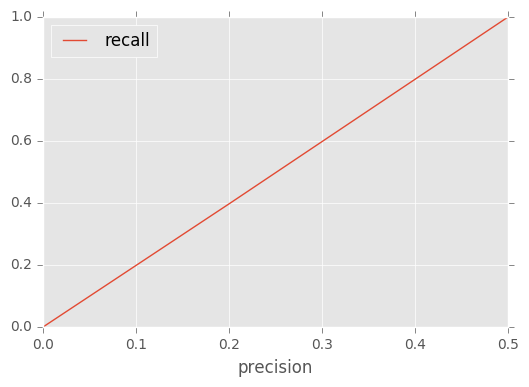

In [34]:
graph_df.sort_values('precision').plot(x='precision', y='recall')